In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_auc_score, plot_roc_curve, accuracy_score
from sklearn.preprocessing import StandardScaler

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import xgboost as xgb

In [9]:
## 4.1 Loading and Cleaning the Data for Comparative Modeling

df = pd.read_csv('data/PS_20174392719_1491204439457_log.csv')

# to make all columns camel case and labeled the same way
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})

# EDA indicated 3 columns were irrelevant:

df = df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

# EDA indicated fraudulent transactions only occur in CASH_OUT and TRANSFER types

df = df[(df['type'] == 'CASH_OUT' ) | (df['type'] == 'TRANSFER')]

#engineered columns 
df['sourceBalanceDiff'] = df['newBalanceOrig'] + df['amount'] - df['oldBalanceOrig']
df['tarBalanceDiff'] = df['oldBalanceDest'] + df['amount'] - df['newBalanceDest']

df = pd.get_dummies(columns = ['type'], drop_first = True, data = df)

X = df.drop(columns = ['isFraud'])
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42, 
                                                    stratify = y)
over = SMOTE(sampling_strategy = 0.1)
X1_train, y1_train = over.fit_resample(X_train, y_train)

under = RandomUnderSampler(sampling_strategy = 0.5)
X2_train, y2_train = under.fit_resample(X_train, y_train)

steps = [('o', over), ('u', under)]
balance_pipe = Pipeline(steps = steps)
X3_train, y3_train = balance_pipe.fit_resample(X_train, y_train)

D_train = xgb.DMatrix(X_train, label = y_train)
D_test = xgb.DMatrix(X_test, label = y_test)

D1_train = xgb.DMatrix(X1_train, label = y1_train)
D1_test = xgb.DMatrix(X_test, label = y_test)

D2_train = xgb.DMatrix(X2_train, label = y2_train)
D2_test = xgb.DMatrix(X_test, label = y_test)

D3_train = xgb.DMatrix(X3_train, label = y3_train)
D3_test = xgb.DMatrix(X_test, label = y_test)

In [10]:
datasets = {
    "Unaltered" : [D_train, D_test],
    "Oversampled Minority" : [D1_train, D1_train],
    "Undersample Majority" : [D2_train, D2_train],
    "Balanced SMOTE" : [D3_train, D3_train]
}

XGBoostError: [14:47:27] ../src/objective/regression_obj.cu:57: Check failed: preds.Size() == info.labels_.Size() (4155612 vs. 2077806) :  labels are not correctly providedpreds.size=4155612, label.size=2077806, Loss: binary:logistic
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000011c7d88be dmlc::LogMessageFatal::~LogMessageFatal() + 110
  [bt] (1) 2   libxgboost.dylib                    0x000000011c8dfcbf xgboost::obj::RegLossObj<xgboost::obj::LogisticClassification>::GetGradient(xgboost::HostDeviceVector<float> const&, xgboost::MetaInfo const&, int, xgboost::HostDeviceVector<xgboost::detail::GradientPairInternal<float> >*) + 447
  [bt] (2) 3   libxgboost.dylib                    0x000000011c889ca1 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 609
  [bt] (3) 4   libxgboost.dylib                    0x000000011c7dd4dc XGBoosterUpdateOneIter + 156
  [bt] (4) 5   libffi.7.dylib                      0x00000001061e6ead ffi_call_unix64 + 85
  [bt] (5) 6   ???                                 0x00007ffeea5365b0 0x0 + 140732829754800



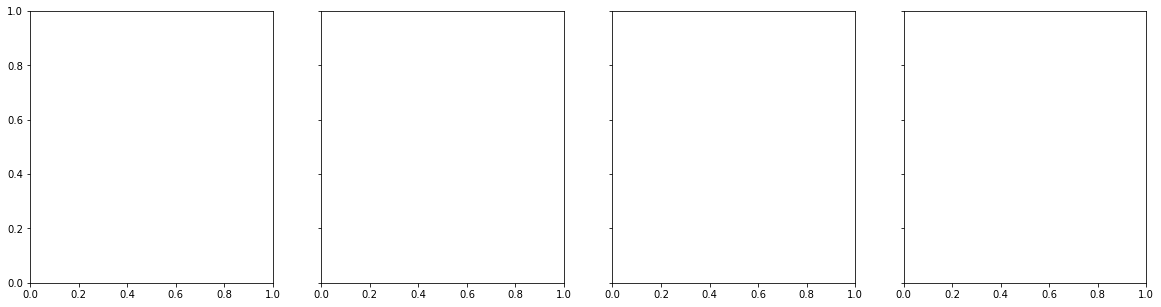

In [12]:
f, axes = plt.subplots(1, 4, figsize = (20, 5), sharey = 'row')

models = []

for i, (key, dataset) in enumerate(datasets.items()):
    params = {
        'eta' : 0.3,
        'max_depth': 5, 
        'objective' : 'binary:logistic',
        'num_class': 2
    }
    steps = 20
    
    model = xgb.train(params, dataset[0], steps)
    y_pred = model.predict(dataset[1])
    cf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax = axes[i])
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    if i != 0:
        disp.ax_.set_ylabel('')
    
    model_dict = {key: model, 'preds': y_pred, 'Confusion Matrix': cf_matrix}
    models.append(model_dict)
        
f.text(0.4, 0.1, 'Predicted Label', ha = 'left')
f.colorbar(disp.im_, ax = axes)
plt.show()